# Подготовка к работе

In [1]:
import pandas as pd
from decimal import Decimal
from sklearn.utils import shuffle
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from pymorphy2 import MorphAnalyzer
from tqdm import tqdm 
from datetime import datetime, date

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Александр\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Для анализа был собран набор данных из 2533 строк. 
По причне отказа Twitter в предоставлении API всем членам команды не удалось проверить возможность обойти ограничения API в семь дней. Однако с помощью библиотеки selenium удалось найти и собрать все необходимые данные.

Гипотеза №1 (есть возможность собрать данные из Twitter, минуя ограничение API в 7 дней) и Гипотеза №2 (есть возможность собрать данные из Twitter без использования API) подтверждены.

Использованный для парсинга код представлен в ноутбуке Parsing tweets from Twitter.ipynb (https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/notebooks/Parsing%20tweets%20from%20Twitter.ipynb). Полученный набор данных twitter_new_raw_data.csv доступен по ссылке https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/parsed_data/twitter_new_raw_data.csv .

# Sentiment-анализ

C использованием моделей ('cointegrated/rubert-tiny-toxicity','SkolkovoInstitute/russian_toxicity_classifier', 'cointegrated/rubert-tiny2-cedr-emotion-detection', 'Aniemore/rubert-tiny2-russian-emotion-detection') было проведено изучение имеющихся твитов. Использование модели 'KoichiYasuoka/bert-base-russian-upos' позволило определить объекты в тексте.
Используемый код находится в ноутбуке по ссылке https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/notebooks/%D0%A2%D0%B5%D0%BF%D0%BB%D0%B8%D1%86%D0%B0_%D1%81%D0%B5%D0%BD%D1%82%D0%B8%D0%BC%D0%B5%D0%BD%D1%82_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%8F_2.ipynb.

Полученные результаты сохранены в csv файле sentiment_from_5_models.csv (https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/parsed_data/sentiment_from_5_models.csv).

# Очистка данных

In [2]:
#https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/parsed_data/sentiment_from_5_models.csv
main_df = pd.read_csv('sentiment_from_5_models.csv',index_col=0, sep=',')
main_df.head(5)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m3_fear,m3_anger,m4_neutral,m4_happiness,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects
0,2022-07-22T20:22:11.000Z,Светлана,@Svetlan99809534,по оценке журнала «Forbes» Керимов стал третьи...,0,0,0,0.999206,0.000774,0.000202,...,0.005459,0.005077,0.987943,0.005911,0.007564,0.005373,0.005333,0.005620,0.003407,керимов жизнь горчакова forbes россии фонд фон...
1,2022-07-18T12:17:28.000Z,Серж,@eATOuWB6hfHqVpc,Хаматова в свой фонд подари жизнь по 1млрд в г...,0,0,4,0.969807,0.032301,0.001154,...,0.004878,0.020253,0.043987,0.348249,0.180201,0.023196,0.002875,0.206812,0.010694,хаматова
2,2022-07-04T05:47:11.000Z,ленаelena,@elena53166542,У Хаматовой денег море. Она обокрал фонд Подар...,2,0,1,0.999454,0.000700,0.000134,...,0.005141,0.005481,0.982843,0.005219,0.011761,0.004467,0.005009,0.005505,0.003115,хаматовой
3,2022-07-02T19:22:11.000Z,Dre1,@DremanerDre1,"Мих, ты не ""Лёняверим"", может кто-либо из твои...",0,0,0,0.999337,0.000653,0.000186,...,0.006284,0.011269,0.697096,0.006642,0.005628,0.087352,0.013222,0.145647,0.007568,лёняверим спартак мих
4,2022-07-01T18:44:57.000Z,"Wishmaster© Vendetta,",–,Дебиторская задолженность фонда «Подари жизнь»...,0,1,3,0.998452,0.001748,0.000132,...,0.004534,0.005451,0.985294,0.005397,0.008487,0.005297,0.004396,0.005548,0.003071,чулпан хаматовой эдвард чесноков


In [3]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2533 entries, 0 to 2532
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                2533 non-null   object 
 1   author              2533 non-null   object 
 2   twitter_name        2533 non-null   object 
 3   text                2533 non-null   object 
 4   number_of_reply     2533 non-null   int64  
 5   number_of_retweets  2533 non-null   int64  
 6   number_of_likes     2533 non-null   int64  
 7   m1_notoxic          2533 non-null   float64
 8   m1_insult           2533 non-null   float64
 9   m1_obscenity        2533 non-null   float64
 10  m1_threat           2533 non-null   float64
 11  m1_dangerous        2533 non-null   float64
 12  m2_neutral          2533 non-null   float64
 13  m2_toxic            2533 non-null   float64
 14  m3_no_emotion       2533 non-null   float64
 15  m3_joy              2533 non-null   float64
 16  m3_sad

In [4]:
main_df.drop(columns=["m1_notoxic", "m1_insult", "m1_obscenity", "m1_threat", "m1_dangerous",  "m2_neutral", "m3_no_emotion", "m3_joy", "m3_sadness", "m3_surprise", "m3_fear", "m3_anger", 'm4_neutral', 'm4_happiness', 'm4_sadness', 'm4_enthusiasm', 'm4_fear', 'm4_anger', 'm4_disgust'], inplace=True)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,m5_objects
0,2022-07-22T20:22:11.000Z,Светлана,@Svetlan99809534,по оценке журнала «Forbes» Керимов стал третьи...,0,0,0,0.069923,керимов жизнь горчакова forbes россии фонд фон...
1,2022-07-18T12:17:28.000Z,Серж,@eATOuWB6hfHqVpc,Хаматова в свой фонд подари жизнь по 1млрд в г...,0,0,4,0.135525,хаматова


In [5]:
main_df['m2_toxic'] = main_df['m2_toxic'].apply(lambda x: int(1) if Decimal(x) > Decimal(0.5) else int(0))

<AxesSubplot:>

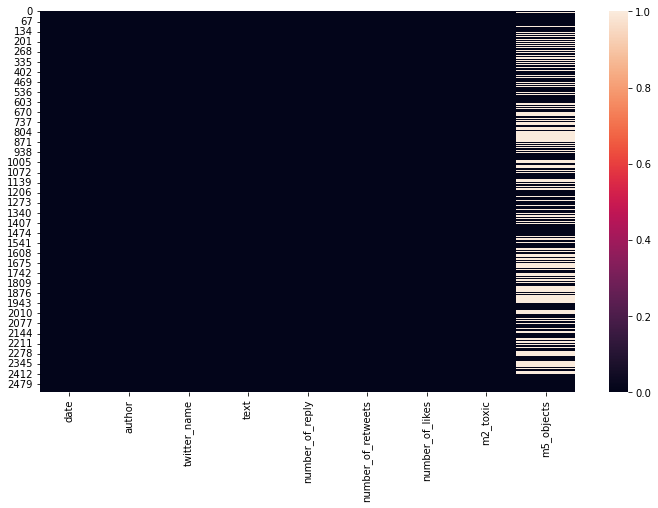

In [6]:
plt.subplots(figsize=(12, 7))
sns.heatmap(main_df.isnull())

In [7]:
# для дальнейшего подсчета
main_df.m5_objects.fillna('пропуск', inplace=True)

In [8]:
main_df = shuffle(main_df)
main_df.reset_index(inplace=True, drop=True)
main_df.head()

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,m5_objects
0,2020-06-10T12:05:26.000Z,А М,@sidelnikoff,"в общем, если буду претендовать на приз, напра...",1,0,1,0,пропуск
1,2012-11-23T17:18:49.000Z,Gleb Romanenko,@glebito,"Фонд ""Подари жизнь"" получит от властей участок...",0,0,0,0,пропуск
2,2012-12-18T21:46:22.000Z,Александр,@QGEIS,"Чулпан Хаматова на канале ""Совершенно секретно...",0,0,0,0,хаматова фонд
3,2016-12-16T10:45:30.000Z,Marina Okhrimovskaya,@Okhrimovskaya,Все собранные средства будут перечислены в фон...,0,0,0,0,пропуск
4,2010-12-01T18:57:46.000Z,Russian Liberator,@rus_liberator,"забота о детях, незарегистрированные лекарства...",0,0,0,0,пропуск


In [9]:
main_df['date'] = main_df['date'].apply(lambda x: x.split('T')[0])
main_df['date'] = main_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime("%Y"))

main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,m5_objects
0,2020,А М,@sidelnikoff,"в общем, если буду претендовать на приз, напра...",1,0,1,0,пропуск
1,2012,Gleb Romanenko,@glebito,"Фонд ""Подари жизнь"" получит от властей участок...",0,0,0,0,пропуск


In [10]:
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return ' '.join(clear_text.split())

In [11]:
main_df['clean_text'] = main_df['text'].apply(clear_text)
main_df['m5_objects'] = main_df['m5_objects'].apply(clear_text)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,m5_objects,clean_text
0,2020,А М,@sidelnikoff,"в общем, если буду претендовать на приз, напра...",1,0,1,0,пропуск,в общем если буду претендовать на приз направь...
1,2012,Gleb Romanenko,@glebito,"Фонд ""Подари жизнь"" получит от властей участок...",0,0,0,0,пропуск,фонд подари жизнь получит от властей участок п...


In [12]:
def clean_stop_words(text : str):
    stop = stopwords.words('russian')
    stop.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...', '>', 'донорыдеть'])
    text = [word for word in text.split() if word not in stop]
    return " ".join(text)

In [13]:
main_df['clean_text'] = main_df['clean_text'].apply(clean_stop_words)
#main_df['m5_objects'] = main_df['m5_objects'].apply(clean_stop_words)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,m5_objects,clean_text
0,2020,А М,@sidelnikoff,"в общем, если буду претендовать на приз, напра...",1,0,1,0,пропуск,общем буду претендовать приз направьте фонд по...
1,2012,Gleb Romanenko,@glebito,"Фонд ""Подари жизнь"" получит от властей участок...",0,0,0,0,пропуск,фонд подари жизнь получит властей участок детс...


In [14]:
morph = MorphAnalyzer()
main_df['clean_text'] = main_df['clean_text'].apply(lambda x: morph.normal_forms(x)[0])
main_df['m5_objects'] = main_df['m5_objects'].apply(lambda x: morph.normal_forms(x)[0])
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,m5_objects,clean_text
0,2020,А М,@sidelnikoff,"в общем, если буду претендовать на приз, напра...",1,0,1,0,пропуск,общем буду претендовать приз направьте фонд по...
1,2012,Gleb Romanenko,@glebito,"Фонд ""Подари жизнь"" получит от властей участок...",0,0,0,0,пропуск,фонд подари жизнь получит властей участок детс...


In [15]:
#Add new feature to DF 'text_lengh'
main_df['text_lengh'] = main_df['text'].apply(lambda x: len(x.strip(' ')))
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,m5_objects,clean_text,text_lengh
0,2020,А М,@sidelnikoff,"в общем, если буду претендовать на приз, напра...",1,0,1,0,пропуск,общем буду претендовать приз направьте фонд по...,93
1,2012,Gleb Romanenko,@glebito,"Фонд ""Подари жизнь"" получит от властей участок...",0,0,0,0,пропуск,фонд подари жизнь получит властей участок детс...,122


In [16]:
for_graph = main_df.groupby(['date']).sum()
for_graph

,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,text_lengh
date,,,,,
2009,0,0,0,1,294
2010,0,4,1,2,8373
2011,8,9,4,5,7737
2012,52,73,14,12,45025
2013,45,619,49,8,19973
2014,43,323,63,7,25704
2015,20,233,64,3,31747
2016,16,152,277,6,22177
2017,71,188,323,11,50010


<AxesSubplot:xlabel='date', ylabel='text_lengh'>

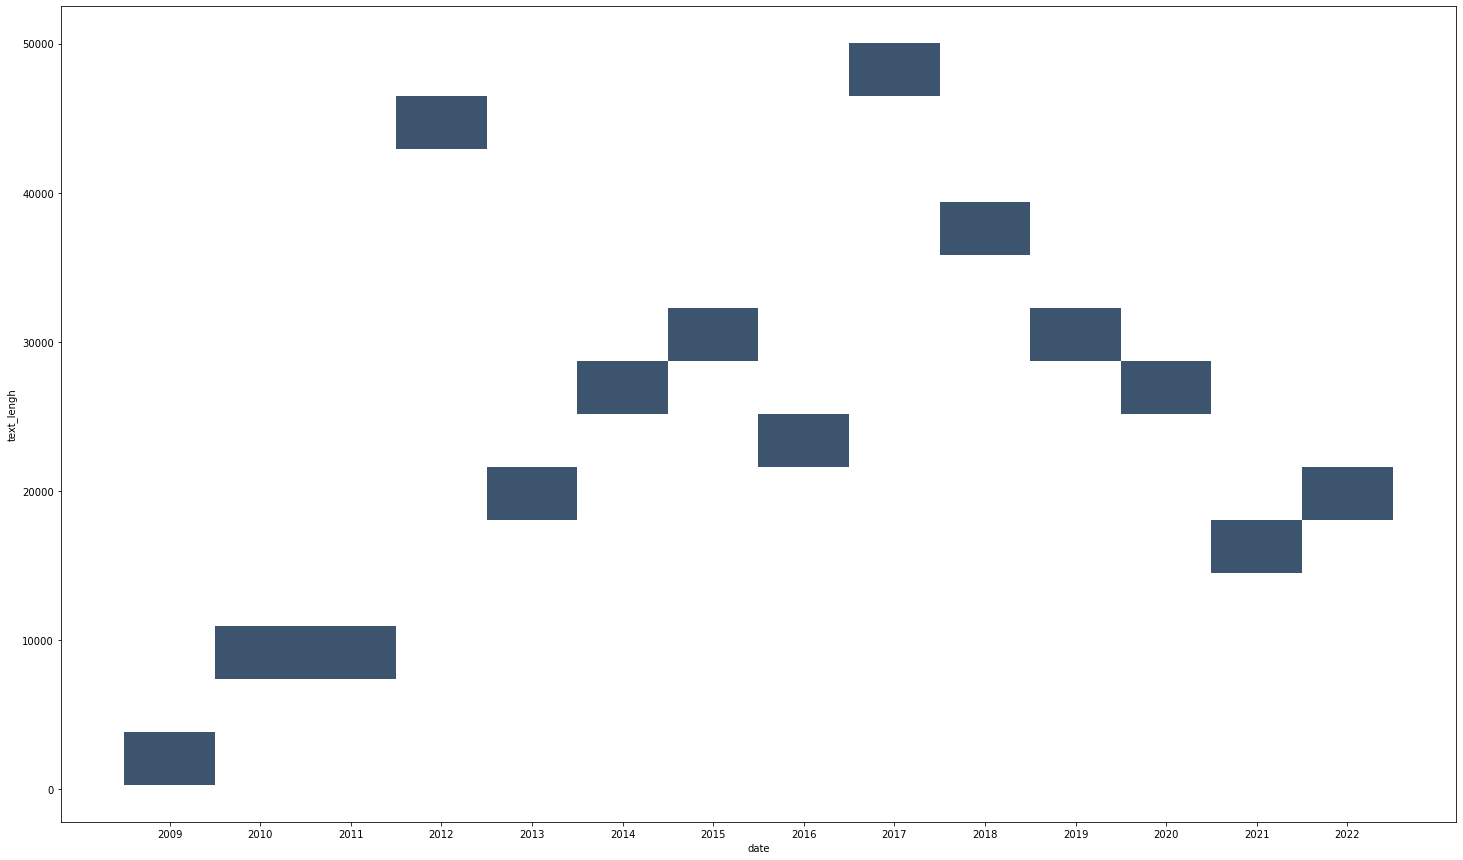

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(25,15)

sns.histplot(data=for_graph, x="date", y='text_lengh', bins=14)

<AxesSubplot:xlabel='date', ylabel='number_of_likes'>

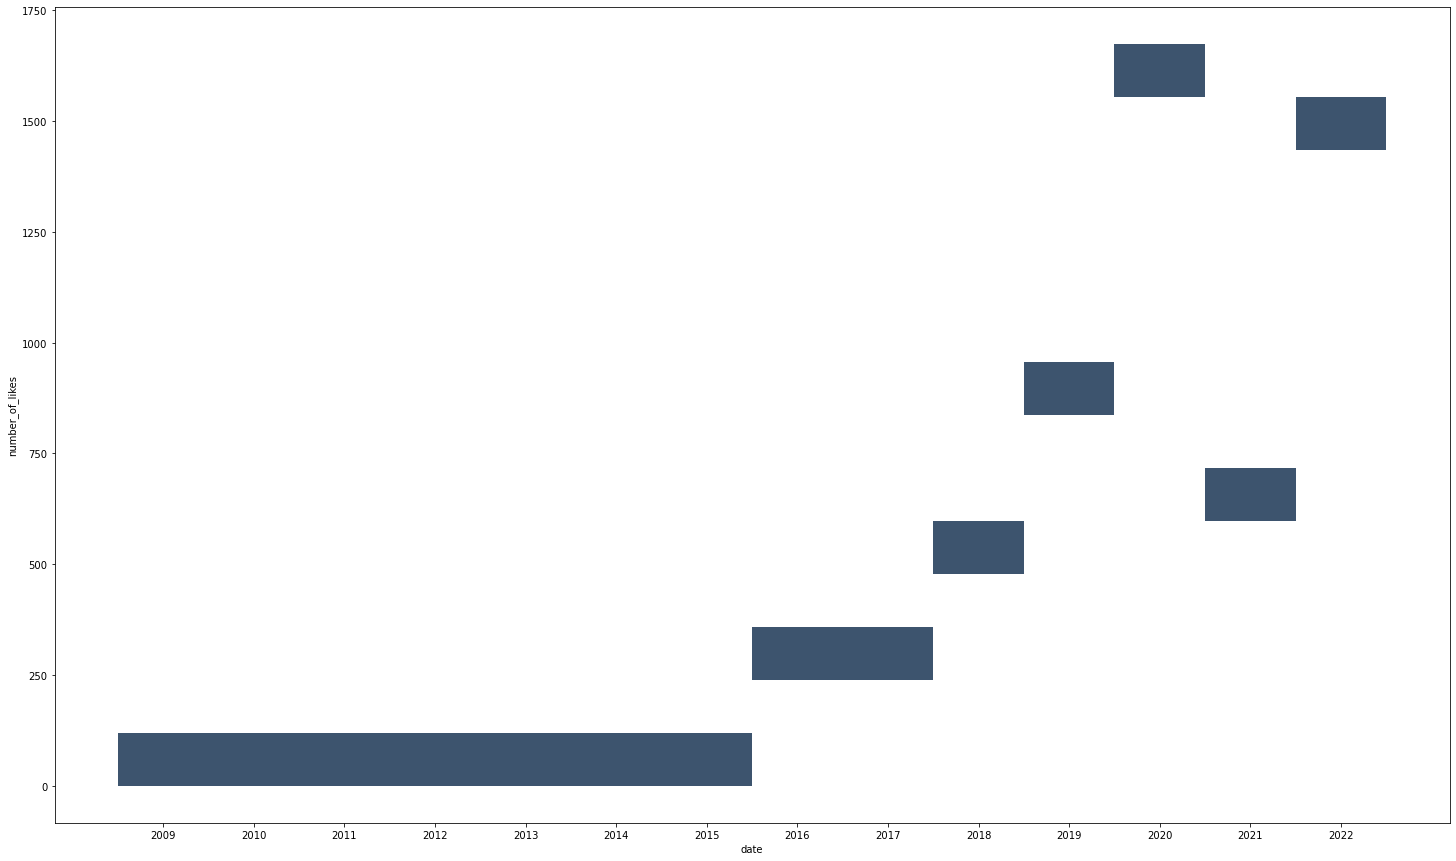

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(25,15)

sns.histplot(data=for_graph, x="date", y='number_of_likes', bins=14)

Число лайков и реттов росло до 2021 года. В 2022 виден резкий рост. То же касается и числа комментариев.
Суммарная длина текстовых сообщения за год росла до 2017 года включительно, после чего неукоснительно снижалась до 2021 года. В 2022 году наблюдается рост.

# Частотный анализ

### Весь объем

In [19]:
Twitter = CountVectorizer(ngram_range=(1, 1))
Twitter_count = Twitter.fit_transform(main_df['clean_text'])
Twitter_frequence = pd.DataFrame({'word':Twitter.get_feature_names(),'frequency':np.array(Twitter_count.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main = Twitter_frequence[:100]

In [20]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main.values))

In [21]:
Twitter_frequence_main['percent'] = Twitter_frequence_main['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))
Twitter_frequence_main[:10]

,word,frequency,percent
6531,фонд,2419,17.573556
1600,жизнь,2394,17.391936
4096,подари,2374,17.246640
315,благотворительный,396,2.876862
6804,чулпан,243,1.765347
4097,подарижизнь,233,1.692699
2510,лечение,199,1.445696
4313,получит,192,1.394842
1258,детский,190,1.380312
6642,хоспис,185,1.343988


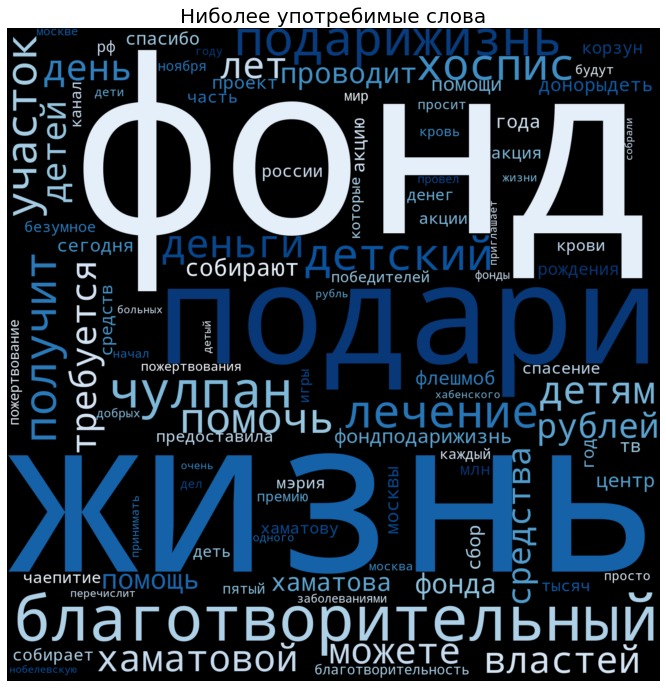

In [22]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Ниболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

In [23]:
all_list = Twitter_frequence_main['word'].tolist()

In [24]:
new_df = main_df[main_df['m2_toxic']==0]

Twitter = CountVectorizer(ngram_range=(1, 1))
Twitter_count = Twitter.fit_transform(new_df['clean_text'])
Twitter_frequence = pd.DataFrame({'word':Twitter.get_feature_names(),'frequency':np.array(Twitter_count.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main = Twitter_frequence[:100]

In [25]:
Twitter_frequence_main['percent'] = Twitter_frequence_main['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))
plus_list = Twitter_frequence_main['word'].tolist()
len(plus_list)

100

In [26]:
for x in all_list:
    if x in plus_list:
        plus_list.remove(x)        
    else:
        continue
len(plus_list)

2

In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2442 entries, 0 to 2532
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                2442 non-null   object
 1   author              2442 non-null   object
 2   twitter_name        2442 non-null   object
 3   text                2442 non-null   object
 4   number_of_reply     2442 non-null   int64 
 5   number_of_retweets  2442 non-null   int64 
 6   number_of_likes     2442 non-null   int64 
 7   m2_toxic            2442 non-null   int64 
 8   m5_objects          2442 non-null   object
 9   clean_text          2442 non-null   object
 10  text_lengh          2442 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 228.9+ KB


Следовательно, несмотря на то, что положительных отзывов имеется 2442 из 2532, 89 слов из 100 в списке наиболее употребимых (all_list совпадает с plus_list только на 21 слово)относятся к отрицательным. Гипотезу №4 (наиболее употребимые слова связаны с деятельностью фонда и носят позитивный характер) можно считать опровергнутой.

## Частотный анализ объектов

In [28]:
Twitter = CountVectorizer(ngram_range=(1, 1))
Twitter_count = Twitter.fit_transform(main_df['m5_objects'])
Twitter_frequence = pd.DataFrame({'word':Twitter.get_feature_names(),'frequency':np.array(Twitter_count.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main = Twitter_frequence[:100]

In [29]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main.values))

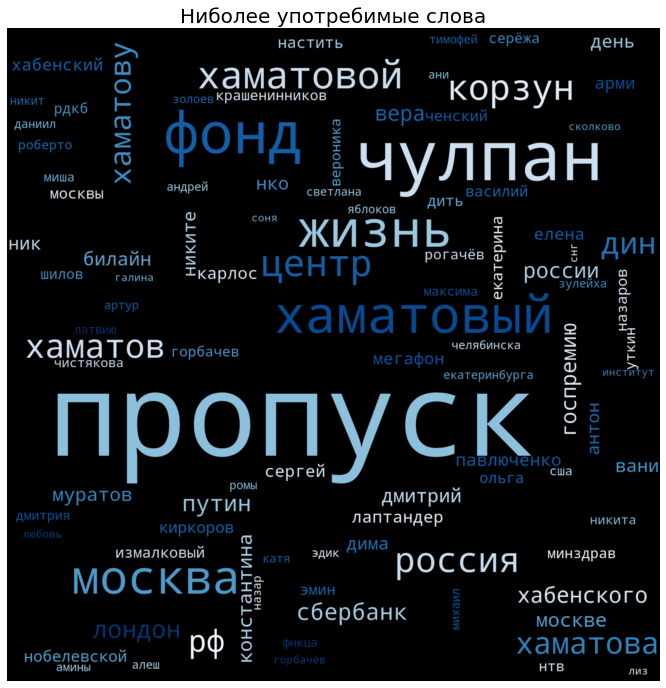

In [30]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Ниболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

In [31]:
Twitter_frequence_main['percent'] = Twitter_frequence_main['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))

In [32]:
chulpan = ['чулпан', 'хаматовый', 'хаматовой', 'хаматов', 'хаматова', 'хаматову']
korzun = ['дин', 'корзун']
Twitter_frequence_main['word'] = Twitter_frequence_main['word'].apply(lambda x: 'чулпан' if x in chulpan else x)
Twitter_frequence_main['word'] = Twitter_frequence_main['word'].apply(lambda x: 'корзун' if x in korzun else x)

In [33]:
Twitter_frequence_main[:20].groupby(['word']).sum()

,frequency,percent
word,,
жизнь,102,3.761062
корзун,80,2.949853
лондон,21,0.774336
москва,85,3.134218
пропуск,1024,37.758112
путин,18,0.663717
россии,16,0.589971
россия,44,1.622419
рф,33,1.216814


Наиболее популярными "объектами" стали Чулпан Хаматова (примерно 17%) - соучредитель фонда, Корзун Дина Александровна (примерно 3%) - соучредитель фонда, а также Константин Хабенский (около 0.6%).  Расчет произведен с учетом общего числа твитов

Остальные объекты связаны с наименованием фонда, сотрудничающими организациями, государственными институтами, топонимами и не имеют такого совокупного веса.

Гипотезу №5 (деятельность фонда ассоциируется с определенными личностями) можно считать подтвержденной.

## Подготовка к оценке негативных отзывов

In [34]:
df_to_analize = main_df
df_to_analize[:5]

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m2_toxic,m5_objects,clean_text,text_lengh
0,2020,А М,@sidelnikoff,"в общем, если буду претендовать на приз, напра...",1,0,1,0,пропуск,общем буду претендовать приз направьте фонд по...,93
1,2012,Gleb Romanenko,@glebito,"Фонд ""Подари жизнь"" получит от властей участок...",0,0,0,0,пропуск,фонд подари жизнь получит властей участок детс...,122
2,2012,Александр,@QGEIS,"Чулпан Хаматова на канале ""Совершенно секретно...",0,0,0,0,хаматова фонд,чулпан хаматова канале совершенно секретно фон...,98
3,2016,Marina Okhrimovskaya,@Okhrimovskaya,Все собранные средства будут перечислены в фон...,0,0,0,0,пропуск,собранные средства будут перечислены фонд пода...,317
4,2010,Russian Liberator,@rus_liberator,"забота о детях, незарегистрированные лекарства...",0,0,0,0,пропуск,забота детях незарегистрированные лекарства ре...,136


In [35]:
# Количество лайков по выборке
print(df_to_analize.number_of_likes.sum(),df_to_analize.number_of_likes.mean())

6038 2.3837347019344652


In [36]:
# Количество ретвитов по выборке
print(df_to_analize.number_of_retweets.sum(),df_to_analize.number_of_retweets.mean())

2988 1.1796288985392815


In [37]:
df_to_analize['m2_toxic'].value_counts()

0    2442
1      91
Name: m2_toxic, dtype: int64

Как видно из приведенной информации, большинство отзывов действительно носит позитивный характер. Гипотезу №3 можно считать подтвержденной.

In [38]:
#df_to_analize.to_csv('prepared_data.csv')

## Оценка негативных отзывов

In [39]:
df_to_analize_neg = df_to_analize.loc[df_to_analize['m2_toxic']==1]

In [40]:
Twitter_neg = CountVectorizer(ngram_range=(1, 1))
Twitter_count_neg = Twitter_neg.fit_transform(df_to_analize_neg['clean_text'])
Twitter_frequence_neg = pd.DataFrame({'word':Twitter_neg.get_feature_names(),'frequency':np.array(Twitter_count_neg.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main_neg = Twitter_frequence_neg[:10]

In [41]:
wordcloud_Twitter_neg = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main_neg.values))

In [42]:
Twitter_frequence_main_neg['percent'] = Twitter_frequence_main_neg['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))
chulpan = ['чулпан', 'хаматовый', 'хаматовой', 'хаматов', 'хаматова', 'хаматову']
korzun = ['дин', 'корзун']
Twitter_frequence_main_neg['word'] = Twitter_frequence_main_neg['word'].apply(lambda x: 'чулпан' if x in chulpan else x)
Twitter_frequence_main_neg['word'] = Twitter_frequence_main_neg['word'].apply(lambda x: 'корзун' if x in korzun else x)
Twitter_frequence_main_neg.groupby(['word']).sum()

,frequency,percent
word,,
благотворительный,10,0.368732
детей,11,0.405605
детям,9,0.331858
жизнь,78,2.876106
подари,78,2.876106
подарижизнь,10,0.368732
фонд,77,2.839233
чулпан,35,1.290560


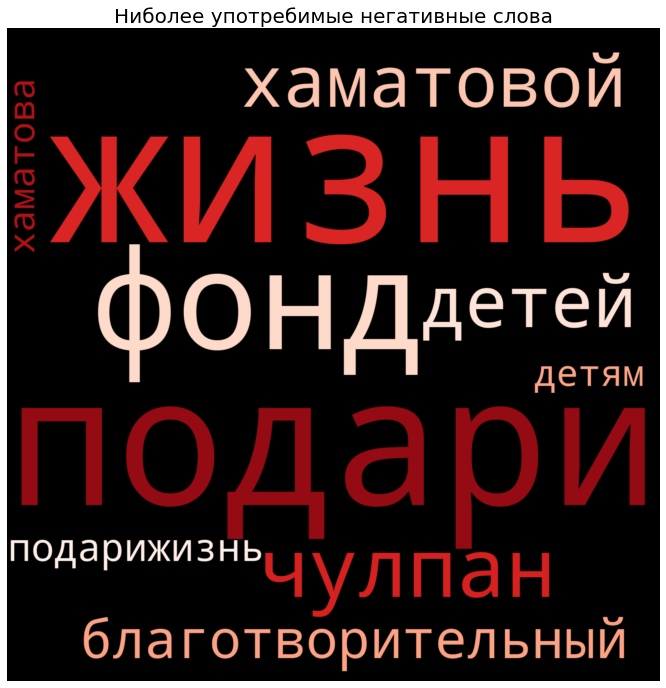

In [43]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter_neg, interpolation='bilinear')
ax.set_title('Ниболее употребимые негативные слова', fontsize = 20)
ax.axis("off")

plt.show()

In [44]:
# Суть негатиивных отзывов не ясна. Вероятно как-то связаны с представителем фондв Чулпан Хаматовой и денежными проблемамию
pd.set_option('display.max_colwidth', -1)
df_to_analize_neg.loc[df_to_analize_neg['date']=='2022'].text

38      пиздец я только сейчас узнала что «подари жизнь» которым столько прикрывали и прикрывают хаматову это даже не фонд хаматовой                                                                                                                                                                                                           
375     Непопулярное мнение : ненавижу фонд подари жизнь, потому что он всегда работал как пропаганда по телеку с больными детьми. Ну и да, сейчас от кризиса детей и людей в России умрет намнооого больше, чем спасли. Я ее ненавижу, но пусть переобувается, если поможет хуйлу свалить.                                                    
531     Какую выгоду она получила? Фонд подари жизнь иностранными агентом не признали, в тюрьму не бросили? Что вы за мудаки то, честное слово?                                                                                                                                                                                         

In [45]:
df_to_analize_neg.loc[df_to_analize_neg['date']=='2021'].text

16      ДЕНЬ ПАМЯТИ #фондподарижизнь @ Гоголь-центр https://instagram.com/p/CPLNmkAJ0GfuJfhxK4gAyEmpHJ0nHV_SVnOpv00/?utm_medium=twitter…                                                                                                   
1535    -Ты крайне критичен к людям! Вот как с Хаматовой.\nИ тут мы переходим к Хаматовой\nЯ: А что с Хаматовой. Хвалит Путина, за это получает денег в фонд “Подари жизнь”. По-моему это аморально.\n-Да как ты смеешь! Она детей спасает!
Name: text, dtype: object

Анализ негативных отзывов  за последнее время показывает, что негативные отзывы, 
по-преимуществу, связаны с политической и культурной позицией учредителя фонда Чулпан Хаматовой и не имеют никакого отношения к деятельности фонда.

In [46]:
for_hist = df_to_analize_neg.groupby('date').count()

<AxesSubplot:xlabel='date', ylabel='author'>

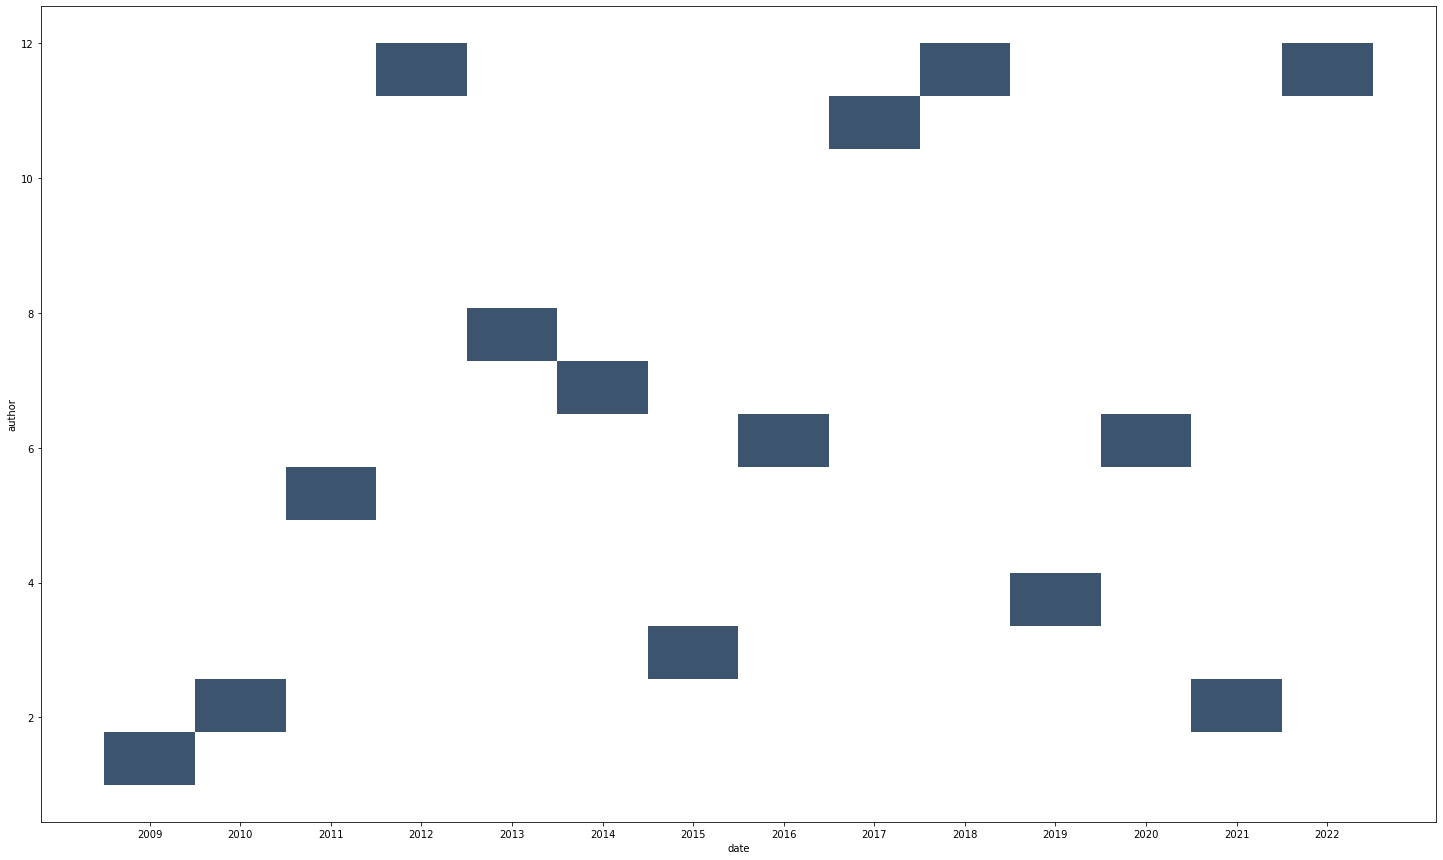

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(25,15)

sns.histplot(data=for_hist, x="date", y='author', bins=14)

Число негативных отзывов после пика 2018 года снижалось до 2021 года. В 2022 году веден стремительный рост числа негативных отзывов

В связи с тем, что позитивные отзывы составляют подавляющее большинство, то результат будет мало отличаться от представленного выше анализа данных в целом. Их отдельный детальный анализ не требуется. Но требуется уточнить основную тематику.

In [48]:
df_to_analize_pos = df_to_analize.loc[df_to_analize['m2_toxic']==0]

<AxesSubplot:xlabel='date', ylabel='author'>

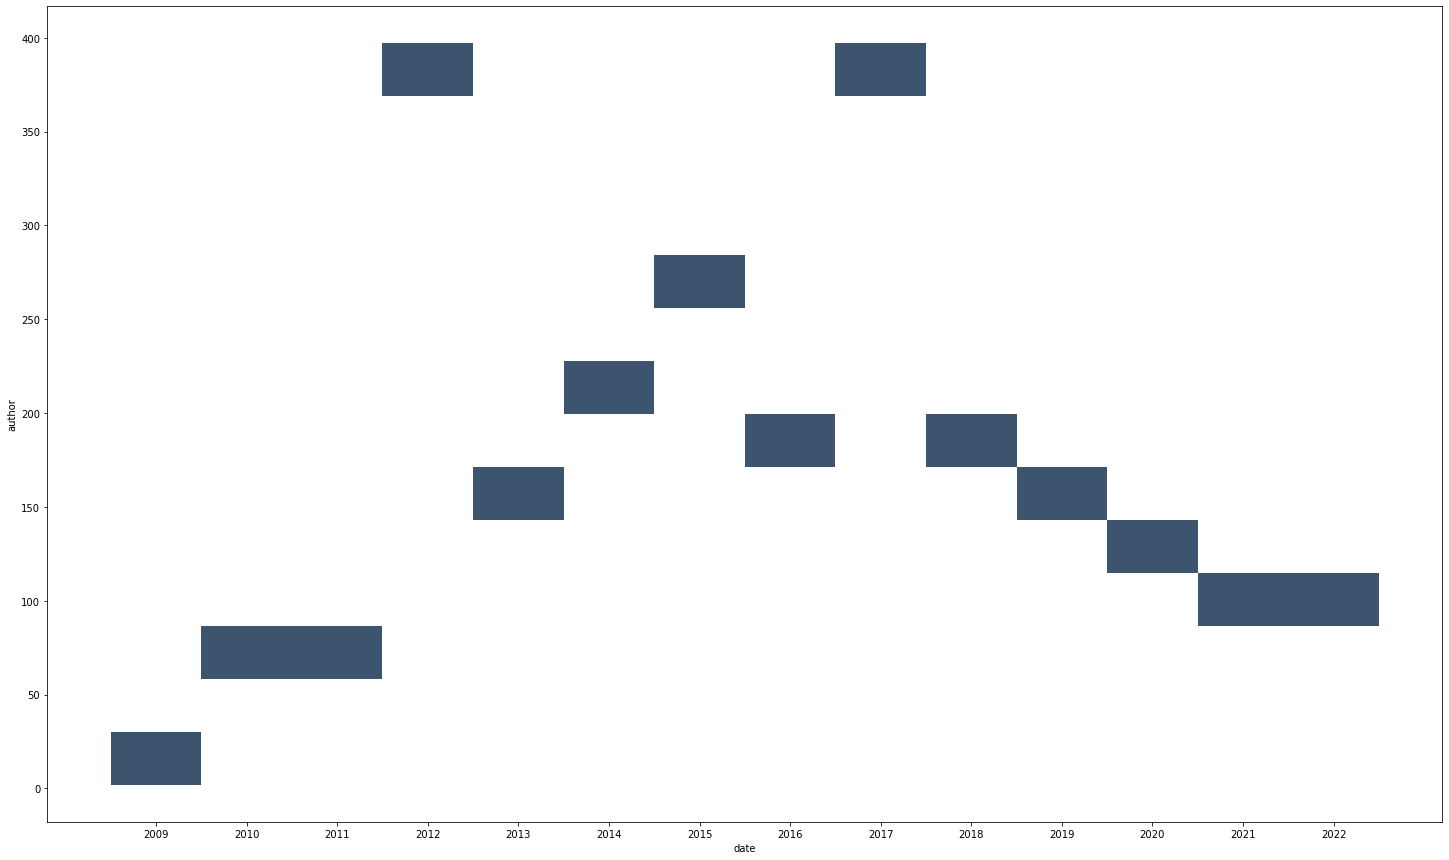

In [49]:
for_hist = df_to_analize_pos.groupby('date').count()

fig, ax = plt.subplots()
fig.set_size_inches(25,15)

sns.histplot(data=for_hist, x="date", y='author', bins=14)

Число позитивных твитов неуклонно снижается. Однако снижение позитивных твитов в 2022 году не является следствием произошедших событий, а представляет собой продолжение объективной тенденции, наметившейся после 2017 года.

In [50]:
Twitter_pos = CountVectorizer(ngram_range=(1, 1))
Twitter_count_pos = Twitter_pos.fit_transform(df_to_analize_pos['clean_text'])
Twitter_frequence_pos = pd.DataFrame({'word':Twitter_pos.get_feature_names(),'frequency':np.array(Twitter_count_pos.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main_pos = Twitter_frequence_pos[:20]

In [51]:
Twitter_frequence_main_neg['percent'] = Twitter_frequence_main_neg['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))
chulpan = ['чулпан', 'хаматовый', 'хаматовой', 'хаматов', 'хаматова', 'хаматову']
korzun = ['дин', 'корзун']
Twitter_frequence_main_neg['word'] = Twitter_frequence_main_neg['word'].apply(lambda x: 'чулпан' if x in chulpan else x)
Twitter_frequence_main_neg['word'] = Twitter_frequence_main_neg['word'].apply(lambda x: 'корзун' if x in korzun else x)
Twitter_frequence_main_neg.groupby(['word']).sum()

,frequency,percent
word,,
благотворительный,10,0.368732
детей,11,0.405605
детям,9,0.331858
жизнь,78,2.876106
подари,78,2.876106
подарижизнь,10,0.368732
фонд,77,2.839233
чулпан,35,1.290560


In [52]:
pd.set_option('display.max_colwidth', -1)
df_to_analize_pos.loc[df_to_analize_pos['date']=='2022'].text

22      Бескрайняя благодарность фонду #ПодариЖизнь за предоставление жизненно необходимого препарата #ксалкори моему ребёнку Маргоше. Препарат реально не из дешёвых (чуть меньше 300000 за упаковку в 60 капсул). Спасибо вам, ребята.                                                                                             
54      https://rusnext.ru/news/1651044708489612?utm_source=social…\nДебиторская задолженность фонда «Подари жизнь», известного как фонд актрисы Чулпан Хаматовой, за 2021 год составила более одного миллиарда рублей. Об этом в своем telegram-канале сообщает российский журналист Эдвард Чесноков. #Россия #Коррупция #RusNext...
58      Антон и Дима поддерживающие фонд "подари жизнь">>>>>>>>                                                                                                                                                                                                                                                                      
63      по оценке журн

Согласно предоставленной выше информации, положительные твиты, по большей части, связаны с деятельностью фонда. Но есть и исключения. В связи с чем Гипотезу №6 (основная тема сообщений связана с деятельностью фонда) следует считать опровергнутой.

## Reaction analyze

In [53]:
new_df = df_to_analize.loc[(df_to_analize['number_of_retweets'] >=3) | (main_df["number_of_likes"] >=3)]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285 entries, 19 to 2529
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                285 non-null    object
 1   author              285 non-null    object
 2   twitter_name        285 non-null    object
 3   text                285 non-null    object
 4   number_of_reply     285 non-null    int64 
 5   number_of_retweets  285 non-null    int64 
 6   number_of_likes     285 non-null    int64 
 7   m2_toxic            285 non-null    int64 
 8   m5_objects          285 non-null    object
 9   clean_text          285 non-null    object
 10  text_lengh          285 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 26.7+ KB


In [54]:
Twitter = CountVectorizer(ngram_range=(1, 1))
Twitter_count = Twitter.fit_transform(new_df['text'])
Twitter_frequence = pd.DataFrame({'word':Twitter.get_feature_names(),'frequency':np.array(Twitter_count.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main = Twitter_frequence[:100]

In [55]:
Twitter_frequence_main

,word,frequency
2562,фонд,267
1040,жизнь,260
1823,подари,257
1477,на,88
431,ru,79
...,...,...
617,благотворительность,7
2085,пятый,7
405,podarizhizn,7
1508,нас,7


In [56]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main.values))

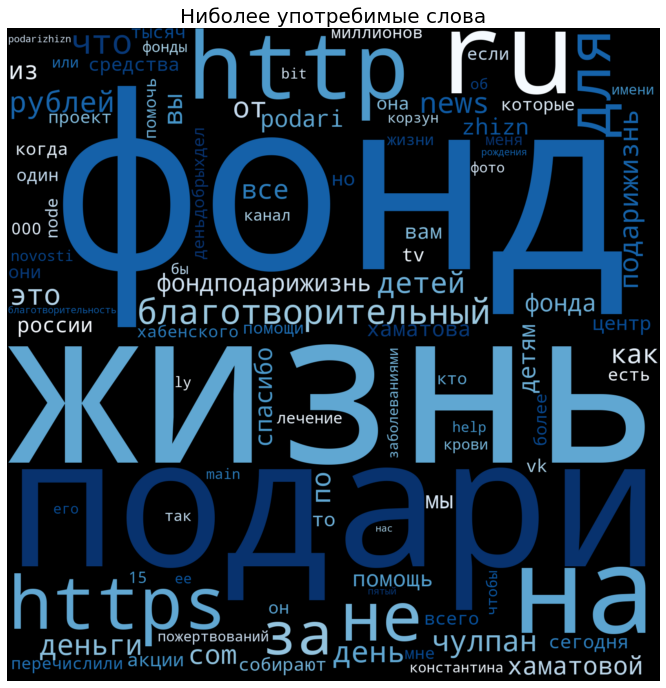

In [57]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Ниболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

In [58]:
new_df.m2_toxic.value_counts()

0    272
1    13 
Name: m2_toxic, dtype: int64

In [59]:
new_df_neg = new_df.loc[new_df['m2_toxic']==1]

In [60]:
pd.set_option('display.max_colwidth', -1)
new_df_neg.loc[new_df_neg['date']>='2022'].text

375     Непопулярное мнение : ненавижу фонд подари жизнь, потому что он всегда работал как пропаганда по телеку с больными детьми. Ну и да, сейчас от кризиса детей и людей в России умрет намнооого больше, чем спасли. Я ее ненавижу, но пусть переобувается, если поможет хуйлу свалить.          
1217    Да, особенно когда доверенной мордой путина была и фонд подари жизнь  с господдержкой содержала.                                                                                                                                                                                             
1637    дима с антоном поддержавшие фонд «подари жизнь» спасли мое уебское настроение                                                                                                                                                                                                                
1967    Чулпан Хаматова эмигрировала в Латвию. \nСказала, что боится возвращаться в Россию. \nА почему? Чем мы ей не у

In [61]:
print(new_df_neg.number_of_likes.sum(),new_df_neg.number_of_likes.mean())

551 42.38461538461539


In [62]:
print(new_df_neg.number_of_retweets.sum(),new_df_neg.number_of_retweets.mean())

177 13.615384615384615


Можно отметить, что выявленные выше негативные отзывы довольно популярны и на порядки превосходят количество лайков и ретвитов в реднем по выборке. В связи с тем, что зачительное число таких отзывов (приперно половина) приходится на последний год: репутация фонда стремительно ухудшается.

In [63]:
new_df_10 = df_to_analize.loc[(df_to_analize['number_of_retweets'] >=10) | (main_df["number_of_likes"] >=10)]
new_df_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 26 to 2529
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                109 non-null    object
 1   author              109 non-null    object
 2   twitter_name        109 non-null    object
 3   text                109 non-null    object
 4   number_of_reply     109 non-null    int64 
 5   number_of_retweets  109 non-null    int64 
 6   number_of_likes     109 non-null    int64 
 7   m2_toxic            109 non-null    int64 
 8   m5_objects          109 non-null    object
 9   clean_text          109 non-null    object
 10  text_lengh          109 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 10.2+ KB


In [64]:
new_df_10.m2_toxic.value_counts()

0    102
1    7  
Name: m2_toxic, dtype: int64

In [65]:
new_df_20 = df_to_analize.loc[(df_to_analize['number_of_retweets'] >=20) | (main_df["number_of_likes"] >=20)]
new_df_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 71 to 2529
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                56 non-null     object
 1   author              56 non-null     object
 2   twitter_name        56 non-null     object
 3   text                56 non-null     object
 4   number_of_reply     56 non-null     int64 
 5   number_of_retweets  56 non-null     int64 
 6   number_of_likes     56 non-null     int64 
 7   m2_toxic            56 non-null     int64 
 8   m5_objects          56 non-null     object
 9   clean_text          56 non-null     object
 10  text_lengh          56 non-null     int64 
dtypes: int64(5), object(6)
memory usage: 5.2+ KB


In [66]:
new_df_20.m2_toxic.value_counts()

0    50
1    6 
Name: m2_toxic, dtype: int64

In [67]:
new_df_30 = df_to_analize.loc[(df_to_analize['number_of_retweets'] >=30) | (main_df["number_of_likes"] >=30)]
new_df_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 71 to 2477
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                41 non-null     object
 1   author              41 non-null     object
 2   twitter_name        41 non-null     object
 3   text                41 non-null     object
 4   number_of_reply     41 non-null     int64 
 5   number_of_retweets  41 non-null     int64 
 6   number_of_likes     41 non-null     int64 
 7   m2_toxic            41 non-null     int64 
 8   m5_objects          41 non-null     object
 9   clean_text          41 non-null     object
 10  text_lengh          41 non-null     int64 
dtypes: int64(5), object(6)
memory usage: 3.8+ KB


In [68]:
new_df_30.m2_toxic.value_counts()

0    37
1    4 
Name: m2_toxic, dtype: int64

Приведенная выше информация показывает, что негативные отзывы находятся среди самых популярных. Однако их число составляет примерно десятую часть всех отзывов.
Гипотезу №7 (сообщения, имеющие наибольшую реакцию, носят преимщественно позитивный характер) можно считать доказанной.